## Library Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import cvxpy as cp
%matplotlib inline

## Helper classes

In [2]:
class Circle():
    def __init__(self, x, y, r):
        self.x = x
        self.y = y
        self.r = r
        
    def get_x(self):
        return self.x
    
    def get_y(self):
        return self.y
    
    def get_r(self):
        return self.r
        
    def draw(self, ax, color):
        circle = plt.Circle((self.x, self.y), self.r, color=color, fill=False)
        ax.add_patch(circle)
        
class Robot(Circle):
    def __init__(self, x, y, r):
        super().__init__(x, y, r)

class Obstacle(Circle):
    def __init__(self, x, y, r):
        super().__init__(x, y, r)

class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def get_x(self):
        return self.x
    
    def get_y(self):
        return self.y
    
    def draw(self, ax, color, marker, size):
        ax.scatter(self.x, self.y, c=color, marker=marker, s=size)

## Environment
- The environment is predefined. Obstacle size and positions are known to the robot during planning.
- Obstacles are circular in shape
- The robot is omni-wheel, omni-directional (holonomic)

In [3]:
class Env:
    def __init__(self, xmin, xmax, ymin, ymax, start, goal):
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        
        self.start = start
        self.goal = goal
        
        self.robot_patch = None
        
        self.obs = []
        self.xstar = []
        
        self.fig, self.ax = plt.subplots(1, 1, figsize=(15,15))
        
    def gen_obs(self, obstacles):
        for ob in obstacles:
            self.obs.append(ob)
        
    def draw_env(self):       
        self.goal.draw(self.ax, 'g', '*', 100)
        self.start.draw(self.ax,'r', '*', 100)
        
        for obstacle in self.obs:
            obstacle.draw(self.ax, 'r')
            
    def draw_path(self, pathx, pathy):
        self.ax.plot(pathx,pathy)
            
    def add_title(self, title):
        self.ax.set_title(title, loc='center', fontweight ="bold")

## Problem Statement
The problem is to find out trajectory for an omni directional robot to reach a predefined goal by avoiding obstacles on the path. 

We solve this problem using **Model Predictive Control** which formulates it as an optimisation problem to find velocity control points at each time step.

## Formulation
- We need to find out velocity vectors $ X $ and $ Y $ which consists of n data points each, where $ n $ is the total number of time steps. 
- The initial ($x_0$, $y_0$) and goal ($x_g, y_g$) position of the robot are known.  
- We have constraints to avoid the circular obstacles and contraints on the velocity, threshold such that it does not exceed a given $v_{max}$.

### Cost Function
$ Cost \; Function $ = $ ((x_0 - x_g) + (\dot{x_0} + \dot{x_1} + \dot{x_2} + \dot{x_3} ... \dot{x_{n-1}}) \delta t)^2 + ((y_0 - y_g) + (\dot{y_0} + \dot{y_1} + \dot{y_2} + \dot{y_3} ... \dot{y_{n-1}}) \delta t)^2 $

- We need to minimize the above cost function, which basically tries to minimize the distance between the robot's current position and goal position.

- The above cost function can be converted to quadratic form as $ \hat{X}^TA\hat{X} + q_1^T\hat{X} + C_1 + \hat{Y}^TB\hat{Y} + q_1^T\hat{Y} + C_2 $

### Obstacle Avoidance
- In case of obstacles, we can introduce the constraint to avoid them : $ ((x_0 - x_{obs}) + (\dot{x_0} + \dot{x_1} + \dot{x_2} + \dot{x_3} ... \dot{x_{n-1}}) \delta t)^2 + ((y_0 - y_{obs}) + (\dot{y_0} + \dot{y_1} + \dot{y_2} + \dot{y_3} ... \dot{y_{n-1}}) \delta t)^2 \geq R^2 $

- The above constraint is not linear. We can use the taylor series expansion around $\hat{X}^*$ and $\hat{Y}^*$ upto 2 terms, these can be computed initially using the optimisation without obstacles and adding random noise(to provide different gradients to the optimiser)

- $f(\hat{X}^*) + \nabla f(\hat{X}^*) (\hat{X} - \hat{X}^*) + f(\hat{Y}^*) + \nabla f(\hat{Y}^*) (\hat{Y} - \hat{Y}^*) \geq R^2$

### Iterative Optimization for each time step, for each obstacle

- The above constraint is applied for every time stamp, for every obstacle.

- We minimize the cost function iteratively. We monitor the final loss after each optimization run and stop when it stops changing much, by setting a threshold. We update $X^*$ in each iteration and hence the point about which we linearize keeps on improving. This gives us a good result after a few iterations (4-6 in usual cases).

In [4]:

class MPC:
    """ 
        MPC class that defines the start and goal, timesteps for trajectory,
        maximum velocity, optimization objective, constraints, and returns an
        optimal trajectory for the robot.
    """
    def __init__(self, env, start, goal, timeStep, robot, steps, maxVelocity):
        self.env = env
        
        self.start = start
        self.goal = goal
        self.robot = robot
        
        self.timeStep = timeStep
        self.steps = steps
        
        self.maxVel = maxVelocity
        self.constraints = []
        self.threshold = 1
    
    def obstacle_constraints(self, X_star, Y_star, ob):
        """
            Return linearized obstacle constraint for an obtacle 
            using taylor series expansion, 
            about a specified point (X_star, Y_star)
        """

        f = -(( self.start.get_x() + X_star.sum() * timeStep - self.env.obs[ob].get_x()) ** 2 \
            + ( self.start.get_y() + Y_star.sum() * timeStep - self.env.obs[ob].get_y()) ** 2 \
            - ( self.env.obs[ob].get_r() + self.robot.get_r() )**2 )

        f_dash =( np.array([-2*timeStep*(start.get_x() + X_star.sum() * timeStep - self.env.obs[ob].get_x())]*len(X_star)),\
                 np.array([-2*timeStep*(start.get_y() + Y_star.sum() * timeStep - self.env.obs[ob].get_y())]*len(Y_star)) )    
        return f, f_dash 
    
    def solve_opt(self):
        """
            Defines the minimization objective, and obstacle, velocity constraints, 
            and solves for optimal trajectory
        """
        X_star, Y_star = np.zeros(shape = self.steps), np.zeros(shape = self.steps)
        # defining the optimization variables 
        X, Y = cp.Variable(shape = (self.steps, 1)), cp.Variable(shape = (self.steps, 1))
        
        prev_loss = np.inf
        while True:
            constraints = []
            
            # for each step
            for step in range(self.steps):
                
                # adding velocity constraints
                constraints.extend([-maxVel <= X[step, 0], 
                                    X[step, 0] <= maxVel, 
                                    -maxVel <= Y[step, 0], 
                                    Y[step, 0] <= maxVel])
                
                # for each obstacle
                for ob in range(len(obstacles)):
                    # obtaining linearized obstacle constraints    
                    f, f_dash = self.obstacle_constraints(X_star[:step+1], Y_star[:step+1], ob)    
                    constraints.append(f + f_dash[0].reshape(1, -1) @ (X[:step+1] - X_star[:step+1].reshape(-1, 1)) +\
                                           f_dash[1].reshape(1, -1) @ (Y[:step+1] - Y_star[:step+1].reshape(-1, 1)) <= 0)
            
            # objective function to be minimized
            objective = cp.Minimize( (start.get_x() + cp.sum(X) * timeStep - goal.get_x()) ** 2 + \
                                     (start.get_y() + cp.sum(Y) * timeStep - goal.get_y()) ** 2)

            # defining the optimization with minimization objective and constraints
            prob = cp.Problem(objective, constraints)
            loss = prob.solve()

            # stop the iteration if the loss doesnt change a lot, by using predefined threshold
            if np.abs(prev_loss - loss) <= self.threshold: 
                break
            prev_loss = loss
            
            # setting X* and Y* for the next iteration 
            X_star = X.value.flatten()
            Y_star = Y.value.flatten()
        
        X_traj,Y_traj = np.array([self.start.get_x(), *np.round(self.start.get_x() + X.value.cumsum() * timeStep)]).astype(np.int32),\
                        np.array([self.start.get_y(), *np.round(self.start.get_y() + Y.value.cumsum() * timeStep)]).astype(np.int32)
        
        return X_traj, Y_traj

## Testing it out
- Keeping a grid of $150 * 150$ 
- Velocity ranging between -5 and +5
- Circular Robot with radius = 1
- 6 circular obstacles   

### Test Case: 1

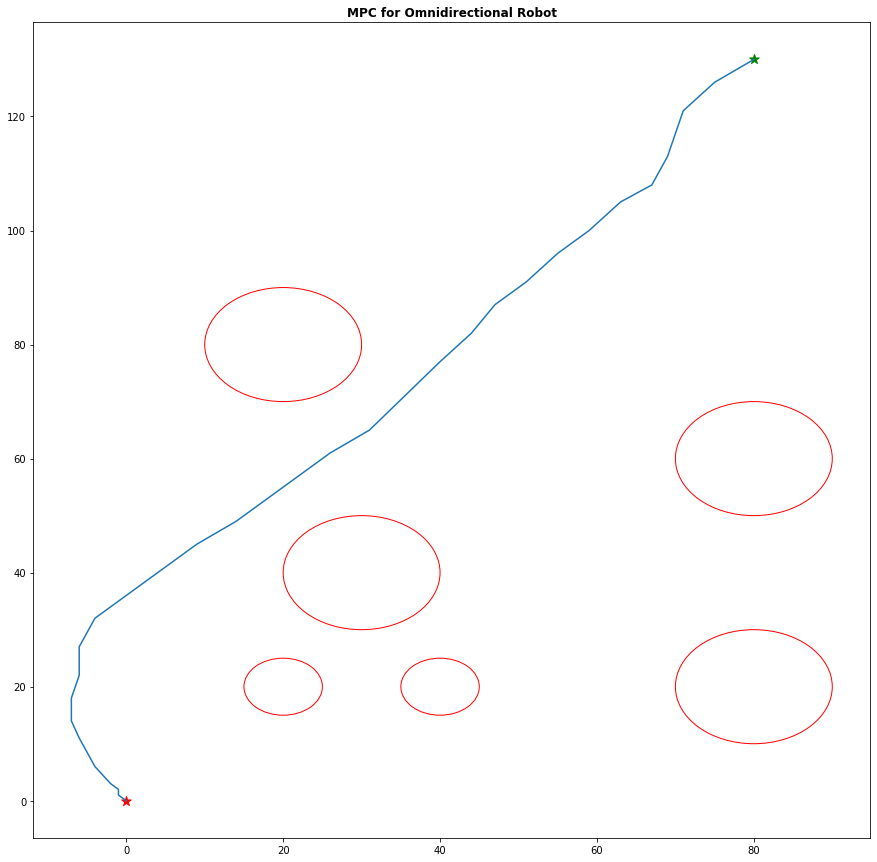

In [5]:
steps = 50 # number of waypoints
    
gridStartX = 0 
gridStartY = 0
gridEndX = 150
gridEndY = 150

timeStep = 1
maxVel = 5
robotRadius = 1

start = Point(0, 0)   
goal = Point(80, 130)

robot = Robot(start.get_x(), start.get_y(), robotRadius)

obstacles = [   Circle(20, 80, 10),
                Circle(30, 40, 10), 
                Circle(40, 20, 5), 
                Circle(20, 20, 5), 
                Circle(80, 60, 10), 
                Circle(80, 20, 10)]

env = Env(gridStartX, gridEndX, gridStartY, gridEndY, start, goal)
env.gen_obs(obstacles)

env.add_title('MPC for Omnidirectional Robot')
env.draw_env()

mpc = MPC(env, start, goal, timeStep, robot, steps, maxVel)
x, y = mpc.solve_opt()
env.draw_path(x,y)




### Test Case: 2

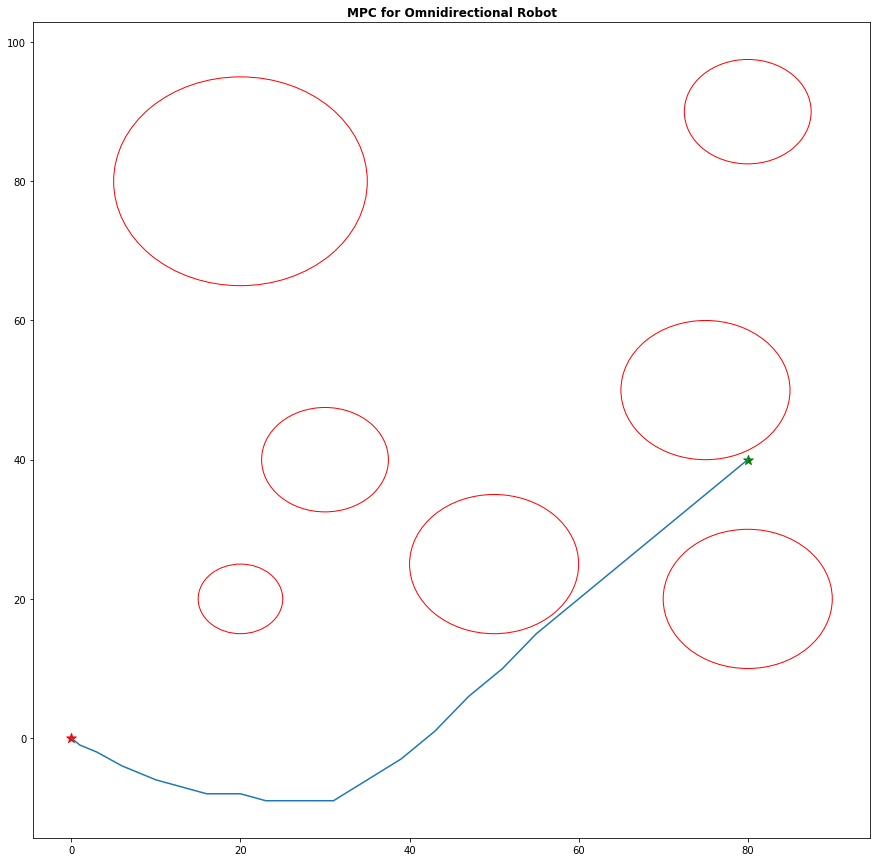

In [6]:
steps = 50 # number of waypoints
    
gridStartX = 0 
gridStartY = 0
gridEndX = 150
gridEndY = 150

timeStep = 1
maxVel = 5
robotRadius = 1

start = Point(0, 0)   
goal = Point(80, 40)

robot = Robot(start.get_x(), start.get_y(), robotRadius)

obstacles = [   Circle(75, 50, 10),
                Circle(50, 25, 10), 
                Circle(30, 40, 7.5), 
                Circle(20, 80, 15), 
                Circle(20, 20, 5), 
                Circle(80, 90, 7.5), 
                Circle(80, 20, 10)
            ]

env = Env(gridStartX, gridEndX, gridStartY, gridEndY, start, goal)
env.gen_obs(obstacles)

env.add_title('MPC for Omnidirectional Robot')
env.draw_env()

mpc = MPC(env, start, goal, timeStep, robot, steps, maxVel)
x, y = mpc.solve_opt()
env.draw_path(x,y)



### Test Case: 3

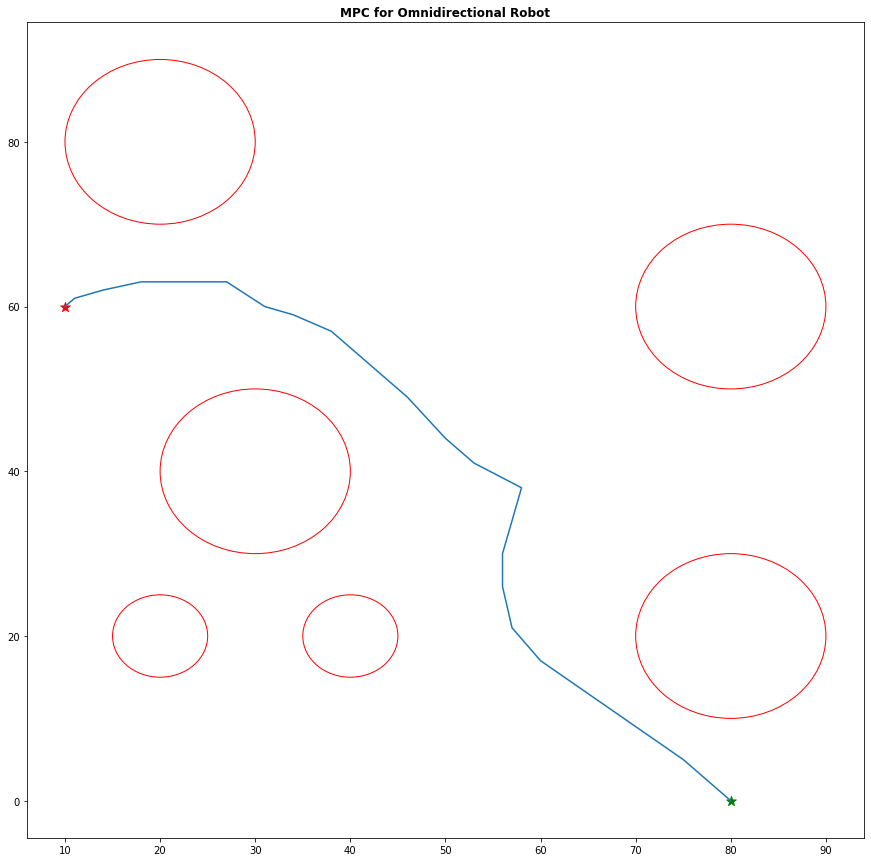

In [7]:
steps = 50 # number of waypoints
    
gridStartX = 0 
gridStartY = 0
gridEndX = 150
gridEndY = 150

timeStep = 1
maxVel = 5
robotRadius = 1

start = Point(10, 60)   
goal = Point(80, 0)

robot = Robot(start.get_x(), start.get_y(), robotRadius)

obstacles = [   Circle(20, 80, 10),
                Circle(30, 40, 10), 
                Circle(40, 20, 5), 
                Circle(20, 20, 5), 
                Circle(80, 60, 10), 
                Circle(80, 20, 10)]

env = Env(gridStartX, gridEndX, gridStartY, gridEndY, start, goal)
env.gen_obs(obstacles)

env.add_title('MPC for Omnidirectional Robot')
env.draw_env()

mpc = MPC(env, start, goal, timeStep, robot, steps, maxVel)
x, y = mpc.solve_opt()
env.draw_path(x,y)



## Contribution
Both members contributed equally.